In [75]:
import sys
import numpy as np
import pandas as pd 
from skmultiflow.data import DataStream, MultilabelGenerator, ConceptDriftStream
from skmultiflow.meta import ClassifierChain
from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier
from skmultiflow.bayes import NaiveBayes
from skmultiflow.metrics import hamming_score
from sklearn.metrics import accuracy_score, f1_score, hamming_loss
#from ld3 import LD3
from skmultilearn.dataset import load_from_arff
from sklearn.preprocessing import MultiLabelBinarizer
from skmultiflow.drift_detection import ADWIN, EDDM, KSWIN, HDDM_W, HDDM_A, DDM, PageHinkley
from sklearn.naive_bayes import GaussianNB
import util
import warnings
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from river.metrics import ExampleF1
from scipy.stats import truncnorm
from tornados.drift_detection import fhddm, fhddms, fhddms_add, mddm_a, mddm_e, mddm_g, rddm, seq_drift2
from tornados.drift_detection.fhddm import FHDDM
from tornados.drift_detection.fhddms import FHDDMS
from tornados.drift_detection.fhddms_add import FHDDMS_add
from tornados.drift_detection.mddm_a import MDDM_A
from tornados.drift_detection.mddm_e import MDDM_E
from tornados.drift_detection.mddm_g import MDDM_G
from tornados.drift_detection.rddm import RDDM
from tornados.drift_detection.seq_drift2 import SeqDrift2ChangeDetector
from ld3_ import LD3, Window, StreamGenerator
from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.lazy import KNNClassifier
from pympler.classtracker import ClassTracker

warnings.filterwarnings('ignore')
np.set_printoptions(precision=4, suppress=True)

In [76]:
'''n_features = 100
n_targets = 20
s1 = MultilabelGenerator(n_samples=6000, n_features=n_features, n_targets=n_targets, n_labels=1, random_state=100) #100
s2 = MultilabelGenerator(n_samples=6009, n_features=n_features, n_targets=n_targets, n_labels=2, random_state=250)
stream = ConceptDriftStream(stream=s1, drift_stream=s2, position=4000, width=1, random_state=0)
sample_size=10000'''

#gen = StreamGenerator()
#stream, sample_size, n_features, n_targets = gen.get_stream(type='benchmark2')

X, y = load_from_arff('./datasets/{}'.format('20NG.arff'), label_count=28)
X = X.toarray()
y = y.toarray().astype(np.int8)
#X, y = util.induce_drift(X, y, 10000, 19300, 20, 1006, percentage=2)
sample_size = len(X)
n_features = X.shape[1]

if len(np.unique(y)) > 2:
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(y)

n_targets = y.shape[1]
stream = DataStream(data = X, y=y, n_targets=n_targets)

  0%|          | 0/19300 [00:00<?, ?it/s]

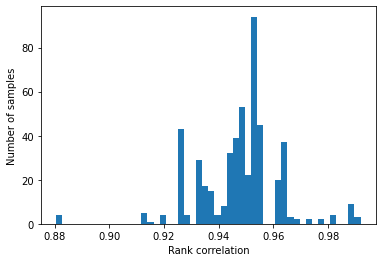

Correlation: 
[0.8819041617125417, 0.8819041617125417, 0.8808626678356858]
Drift@ 2750


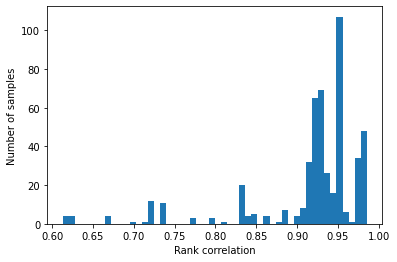

Correlation: 
[0.6127788009375374, 0.6127788009375374, 0.612767465837091, 0.612767465837091, 0.612767465837091]
Drift@ 4909


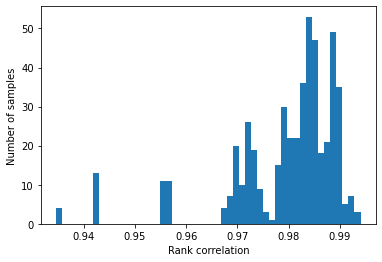

Correlation: 
[0.9346400101758323, 0.9346400101758323, 0.9345892585006677, 0.9345892585006677, 0.9345892585006677]
Drift@ 7102


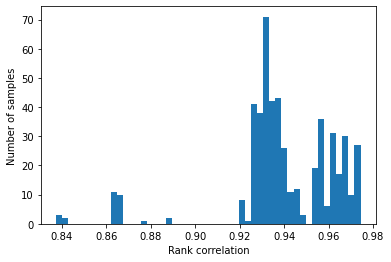

Correlation: 
[0.8381257156597551, 0.8374743346720568, 0.8374743346720568]
Drift@ 9439


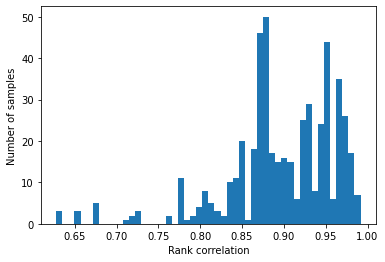

Correlation: 
[0.6277991694703597, 0.6277991694703597, 0.6277991694703597, 0.6277991694703597]
Drift@ 11039


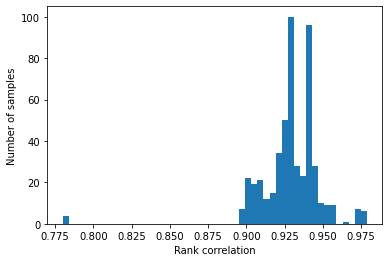

Correlation: 
[0.7799938544797732, 0.7799915686889514, 0.7797734098566115]
Drift@ 15584


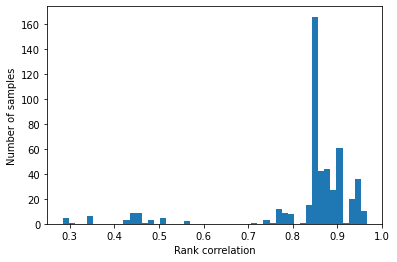

Correlation: 
[0.2841057806947096, 0.2841057806947096, 0.2841057806947096, 0.2841057806947096]
Drift@ 17250

0.1156
0.164
0.241
0.2072
0.1991

---- SUMMARY ------------------------------------------------------------------
                                         active      0     B      average   pct
  LD3                                         1      3.80 KB      3.80 KB    0%
                                         active      0     B      average   pct
  LD3                                         1    243.84 KB    243.84 KB    0%
-------------------------------------------------------------------------------


In [77]:
thresh = [2]
for t in thresh:
    detector = LD3(window_size=500, correlation_thresh=4, len=2, max_window_size=500) #20NG-0.06   Synthetic_sudden-0.01    tmc 0.4-4/5     imbd 0.15     ohsumed 0.5
    clf = ClassifierChain(GaussianNB())#PassiveAggressiveClassifier(random_state=0))
    pre_sample = [np.zeros(n_features), np.zeros(n_features)]
    pre_label = [np.ones(n_targets), np.zeros(n_targets)]
    clf.fit(np.array(pre_sample), np.array(pre_label))
    tracker = ClassTracker()
    tracker.track_object(detector)
    tracker.create_snapshot()

    stream.restart()
    max_samples = sample_size
    y_true = []
    y_pred = []
    pretrain_X = []
    pretrain_y = []
    p_bar = tqdm(total=max_samples)
    n_samples = 0
    drift, warning = False, False
    correlation = 0
    while n_samples < max_samples and stream.has_more_samples():
        X, y = stream.next_sample()
        #w_x.queue(X.flatten())
        #w_y.queue(y)
        #w_y.queue(y.flatten())
        '''if n_samples % 60 == 0 and n_samples > 0:
            clf.reset()
            clf.fit(np.array(pre_sample), np.array(pre_label))
            try:
                clf.fit(w_x.get_window, w_y.get_window)
            except:
                clf.fit(np.array(pre_sample), np.array(pre_label))'''
                
        '''if n_samples >= 10000 and n_samples <= 10500:
            pass
            #print('Correlation @', n_samples, ': ', score, correlation)
            #print(detector._average_correlation)
            #r1, r2 = detector._ranks
            #print('[',','.join(list(map(str,r1))), ']', '\t[', ','.join(list(map(str,r2))), ']')'''
        if drift:
            print('Drift@', n_samples)
            r1, r2 = detector._ranks
            #print('[',','.join(list(map(str,r1))), ']', '\t[', ','.join(list(map(str,r2))), ']')
            clf.reset()
            clf.fit(np.array(pre_sample), np.array(pre_label))
            '''try:
                clf.fit(w_x.get_window, w_y.get_window)
            except:
                w_x.queue(pre_sample[0])
                w_x.queue(pre_sample[1])
                w_y.queue(pre_label[0])
                w_y.queue(pre_label[1])
                clf.fit(w_x.get_window, w_y.get_window)'''

        pred = clf.predict(X)
        #clf.partial_fit(X, np.array([y]))
        clf.partial_fit(X, y)
        drift, warning, correlation, score = detector.update(pred.astype(np.int32))
        #detector.add_element(np.all(pred.flatten() == y))

        #y_true.append(y)
        y_true.extend(y)
        y_pred.extend(pred)

        p_bar.update(1)
        n_samples += 1
    p_bar.close()
    tracker.create_snapshot()
    stream.restart()
    


    print()
    print(np.round(util.accuracy_example(np.array([y_true]), np.array([y_pred])), decimals=4)) # 
    print(np.round(util.hamming_loss(np.array(y_true), np.array(y_pred)), decimals=4))
    print(np.round(f1_score(np.array(y_true), np.array(y_pred), average='samples'),decimals=4))#util.f1_example(np.array([y_true]), np.array([y_pred])))
    print(np.round(util.f1_micro(np.array(y_true), np.array(y_pred)), decimals=4))
    print(np.round(util.f1_macro(np.array(y_true), np.array(y_pred)), decimals=4))
    print()
    tracker.stats.print_summary()

In [78]:
results_pred = []
results_true= y_true
results_pred.append(y_pred)

In [79]:
thresh = [2]
for t in thresh:
    detector = LD3(window_size=500, correlation_thresh=128, len=600, max_window_size=500) #20NG-0.06   Synthetic_sudden-0.01    tmc 0.4-4/5     imbd 0.15     ohsumed 0.5
    clf = ClassifierChain(GaussianNB())#PassiveAggressiveClassifier(random_state=0))
    pre_sample = [np.zeros(n_features), np.zeros(n_features)]
    pre_label = [np.ones(n_targets), np.zeros(n_targets)]
    clf.fit(np.array(pre_sample), np.array(pre_label))
    tracker = ClassTracker()
    tracker.track_object(detector)
    tracker.create_snapshot()

    stream.restart()
    max_samples = sample_size
    y_true = []
    y_pred = []
    pretrain_X = []
    pretrain_y = []
    p_bar = tqdm(total=max_samples)
    n_samples = 0
    drift, warning = False, False
    correlation = 0
    while n_samples < max_samples and stream.has_more_samples():
        X, y = stream.next_sample()
        #w_x.queue(X.flatten())
        #w_y.queue(y)
        #w_y.queue(y.flatten())
        '''if n_samples % 60 == 0 and n_samples > 0:
            clf.reset()
            clf.fit(np.array(pre_sample), np.array(pre_label))
            try:
                clf.fit(w_x.get_window, w_y.get_window)
            except:
                clf.fit(np.array(pre_sample), np.array(pre_label))'''
                
        '''if n_samples >= 10000 and n_samples <= 10500:
            pass
            #print('Correlation @', n_samples, ': ', score, correlation)
            #print(detector._average_correlation)
            #r1, r2 = detector._ranks
            #print('[',','.join(list(map(str,r1))), ']', '\t[', ','.join(list(map(str,r2))), ']')'''
        if drift:
            print('Drift@', n_samples)
            r1, r2 = detector._ranks
            #print('[',','.join(list(map(str,r1))), ']', '\t[', ','.join(list(map(str,r2))), ']')
            clf.reset()
            clf.fit(np.array(pre_sample), np.array(pre_label))
            '''try:
                clf.fit(w_x.get_window, w_y.get_window)
            except:
                w_x.queue(pre_sample[0])
                w_x.queue(pre_sample[1])
                w_y.queue(pre_label[0])
                w_y.queue(pre_label[1])
                clf.fit(w_x.get_window, w_y.get_window)'''

        pred = clf.predict(X)
        #clf.partial_fit(X, np.array([y]))
        clf.partial_fit(X, y)
        drift, warning, correlation, score = detector.update(pred.astype(np.int32))
        #detector.add_element(np.all(pred.flatten() == y))

        #y_true.append(y)
        y_true.extend(y)
        y_pred.extend(pred)

        p_bar.update(1)
        n_samples += 1
    p_bar.close()
    tracker.create_snapshot()
    stream.restart()
    


    print()
    print(np.round(util.accuracy_example(np.array([y_true]), np.array([y_pred])), decimals=4)) # 
    print(np.round(util.hamming_loss(np.array(y_true), np.array(y_pred)), decimals=4))
    print(np.round(f1_score(np.array(y_true), np.array(y_pred), average='samples'),decimals=4))#util.f1_example(np.array([y_true]), np.array([y_pred])))
    print(np.round(util.f1_micro(np.array(y_true), np.array(y_pred)), decimals=4))
    print(np.round(util.f1_macro(np.array(y_true), np.array(y_pred)), decimals=4))
    print()
    results_pred.append(y_pred)
    tracker.stats.print_summary()

  0%|          | 0/19300 [00:00<?, ?it/s]


0.1166
0.2621
0.2313
0.2088
0.2367

---- SUMMARY ------------------------------------------------------------------
                                         active      0     B      average   pct
  LD3                                         1      3.86 KB      3.86 KB    0%
                                         active      0     B      average   pct
  LD3                                         1    243.91 KB    243.91 KB    0%
-------------------------------------------------------------------------------


In [80]:
detectors = [ADWIN(), HDDM_A()]#ADWIN(), EDDM(), DDM(), KSWIN(), HDDM_A(), HDDM_W()]
for detector in detectors:
    #detector = EDDM()#LD3(k=1, window_size=500)
    clf = ClassifierChain(GaussianNB())#SGDClassifier(max_iter=1000, random_state=0))#
    pre_sample = [np.zeros(n_features), np.zeros(n_features)]
    pre_label = [np.ones(n_targets), np.zeros(n_targets)]
    clf.fit(np.array(pre_sample), np.array(pre_label))
    tracker = ClassTracker()
    tracker.track_object(detector)
    tracker.create_snapshot()

    stream.restart()
    max_samples = sample_size
    y_true = []
    y_pred = []
    pretrain_X = []
    pretrain_y = []
    p_bar = tqdm(total=max_samples)
    n_samples = 0
    w_x = Window(max_size=199)
    w_y = Window(max_size=199)
    while n_samples < max_samples and stream.has_more_samples():
        X, y = stream.next_sample()
        #w_x.queue(X.flatten())
        #w_y.queue(y)
        if detector.detected_change():
            print('Drift@', n_samples)
            detector.reset()
            clf.reset()
            clf.fit(np.array(pre_sample), np.array(pre_label))
            '''try:
                clf.fit(w_x.get_window, w_y.get_window)
            except:
                clf.fit(np.array(pre_sample), np.array(pre_label))'''

        pred = clf.predict(X)
        #clf.partial_fit(X, np.array([y]))
        clf.partial_fit(X, y)
        #detector.add_element(pred.astype(np.int32))
        #detector.add_element(np.all(pred.flatten() == y))
        detector.add_element((pred.astype(np.int32).flatten().tolist())==(y.astype(np.int32).flatten().tolist()))

        #y_true.append(y)
        y_true.extend(y)
        y_pred.extend(pred)

        p_bar.update(1)
        n_samples += 1
    
    tracker.create_snapshot()
    print()
    print(np.round(util.accuracy_example(np.array([y_true]), np.array([y_pred])), decimals=4)) # 
    print(np.round(util.hamming_loss(np.array(y_true), np.array(y_pred)), decimals=4))
    print(np.round(f1_score(np.array(y_true), np.array(y_pred), average='samples'),decimals=4))#util.f1_example(np.array([y_true]), np.array([y_pred])))
    print(np.round(util.f1_micro(np.array(y_true), np.array(y_pred)), decimals=4))
    print(np.round(util.f1_macro(np.array(y_true), np.array(y_pred)), decimals=4))
    print()
    tracker.stats.print_summary()
    results_pred.append(y_pred)
   

    stream.restart()


  0%|          | 0/19300 [00:00<?, ?it/s]

Drift@ 9215
Drift@ 15359
Drift@ 17407
Drift@ 18719

0.1241
0.197
0.2599
0.2208
0.2182

---- SUMMARY ------------------------------------------------------------------
                                         active      0     B      average   pct
  ADWIN                                       1      2.95 KB      2.95 KB    0%
                                         active      0     B      average   pct
  ADWIN                                       1      6.10 KB      6.10 KB    0%
-------------------------------------------------------------------------------


  0%|          | 0/19300 [00:00<?, ?it/s]


0.1166
0.2621
0.2313
0.2088
0.2367

---- SUMMARY ------------------------------------------------------------------
                                         active      0     B      average   pct
  HDDM_A                                      1      1.33 KB      1.33 KB    0%
                                         active      0     B      average   pct
  HDDM_A                                      1      1.45 KB      1.45 KB    0%
-------------------------------------------------------------------------------


In [81]:
detectors = [RDDM()]#FHDDM(), FHDDMS(), FHDDMS_add(), MDDM_A(), MDDM_E(), MDDM_G(), SeqDrift2ChangeDetector(), RDDM()]
for detector in detectors:
    #detector = EDDM()#LD3(k=1, window_size=500)
    clf = ClassifierChain(GaussianNB())#SGDClassifier(max_iter=1000, random_state=0))#
    pre_sample = [np.zeros(n_features), np.zeros(n_features)]
    pre_label = [np.ones(n_targets), np.zeros(n_targets)]
    clf.fit(np.array(pre_sample), np.array(pre_label))
    tracker = ClassTracker()
    tracker.track_object(detector)
    tracker.create_snapshot()

    stream.restart()
    max_samples = sample_size
    y_true = []
    y_pred = []
    pretrain_X = []
    pretrain_y = []
    p_bar = tqdm(total=max_samples)
    n_samples = 0
    drift = False
    w_x = Window(max_size=199)
    w_y = Window(max_size=199)
    while n_samples < max_samples and stream.has_more_samples():
        X, y = stream.next_sample()
        #w_x.queue(X.flatten())
        #w_y.queue(y)
        if drift:
            print('Drift@', n_samples)
            detector.reset()
            clf.reset()
            clf.fit(np.array(pre_sample), np.array(pre_label))
            '''try:
                clf.fit(w_x.get_window, w_y.get_window)
            except:
                clf.fit(np.array(pre_sample), np.array(pre_label))'''

        pred = clf.predict(X)
        #clf.partial_fit(X, np.array([y]))
        clf.partial_fit(X, y)
        #detector.add_element(pred.astype(np.int32))
        #detector.add_element(np.all(pred.flatten() == y))
        _, drift = detector.run((pred.astype(np.int32).flatten().tolist())==(y.astype(np.int32).flatten().tolist()))

        #y_true.append(y)
        y_true.extend(y)
        y_pred.extend(pred)

        p_bar.update(1)
        n_samples += 1
    tracker.create_snapshot()
    tracker.stats.print_summary()
    print()
    print(np.round(util.accuracy_example(np.array([y_true]), np.array([y_pred])), decimals=4)) # 
    print(np.round(util.hamming_loss(np.array(y_true), np.array(y_pred)), decimals=4))
    print(np.round(f1_score(np.array(y_true), np.array(y_pred), average='samples'),decimals=4))#util.f1_example(np.array([y_true]), np.array([y_pred])))
    print(np.round(util.f1_micro(np.array(y_true), np.array(y_pred)), decimals=4))
    print(np.round(util.f1_macro(np.array(y_true), np.array(y_pred)), decimals=4))
    print()
    
    results_pred.append(y_pred)
    
    stream.restart()

  0%|          | 0/19300 [00:00<?, ?it/s]

Drift@ 2045
Drift@ 3456
Drift@ 5112
Drift@ 8039
Drift@ 10046
Drift@ 11721
Drift@ 13428
Drift@ 14901
Drift@ 16179
Drift@ 17042
Drift@ 18414
---- SUMMARY ------------------------------------------------------------------
                                         active      0     B      average   pct
  RDDM                                        1     62.24 KB     62.24 KB    0%
                                         active      0     B      average   pct
  RDDM                                        1     62.54 KB     62.54 KB    0%
-------------------------------------------------------------------------------

0.0994
0.1731
0.221
0.1808
0.171



In [82]:
len(results_pred)

5

In [91]:
accs_= []
hamms_ = []
f1exs_ = []
f1mics_ = []
f1macs_ = []

for i in [0,2,3,4,1]:
    index = len(results_pred[i]) // 20
    accs= []
    hamms = []
    f1exs = []
    f1mics = []
    f1macs = []
    for j in range(20):
        accs.append(np.round(util.accuracy_example(np.array([results_true[j*index:(j+1)*index]]), np.array([results_pred[i][j*index:(j+1)*index]])), decimals=4))
        hamms.append(np.round(util.hamming_loss(np.array(results_true[j*index:(j+1)*index]), np.array(results_pred[i][j*index:(j+1)*index])), decimals=4))
        f1exs.append(np.round(f1_score(np.array(results_true[j*index:(j+1)*index]), np.array(results_pred[i][j*index:(j+1)*index]), average='samples'),decimals=4))
        f1mics.append(np.round(util.f1_micro(np.array(results_true[j*index:(j+1)*index]), np.array(results_pred[i][j*index:(j+1)*index])), decimals=4))
        f1macs.append(np.round(util.f1_macro(np.array(results_true[j*index:(j+1)*index]), np.array(results_pred[i][j*index:(j+1)*index])), decimals=4))
    accs_.append(accs)
    hamms_.append(hamms)
    f1exs_.append(f1exs)
    f1mics_.append(f1mics)
    f1macs_.append(f1macs)
    

ValueError: Samplewise metrics are not available outside of multilabel classification.

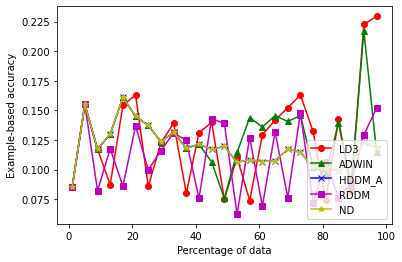

In [84]:
arange = np.arange(1, 101, step=5)
colors = ['ro-', 'g^-', 'bx-', 'ms-', 'y*-']
labels = ['LD3', 'ADWIN', 'HDDM_A', 'RDDM', 'ND']
for i in range(5):
    plt.plot(arange, accs_[i], colors[i], label=labels[i])

plt.xlabel('Percentage of data')
plt.xticks([0,20,40,60,80,100])
plt.ylabel('Example-based accuracy')
plt.legend(loc='lower right')
plt.show()

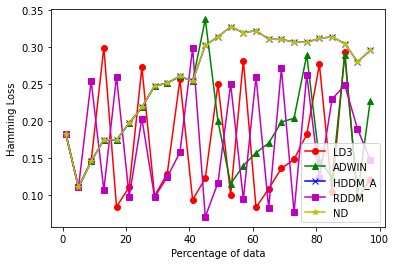

In [85]:
arange = np.arange(1, 101, step=4)
colors = ['ro-', 'g^-', 'bx-', 'ms-', 'y*-']
labels = ['LD3', 'ADWIN', 'HDDM_A', 'RDDM', 'ND']
for i in range(5):
    plt.plot(arange, hamms_[i], colors[i], label=labels[i])

plt.xlabel('Percentage of data')
plt.xticks([0,20,40,60,80,100])
plt.ylabel('Hamming Loss')
plt.legend(loc='lower right')
plt.show()

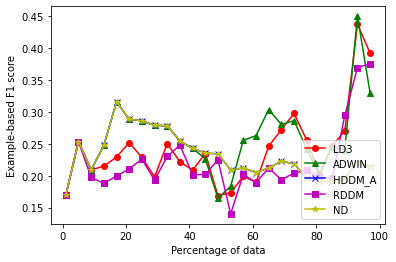

In [86]:
arange = np.arange(1, 101, step=4)
colors = ['ro-', 'g^-', 'bx-', 'ms-', 'y*-']
labels = ['LD3', 'ADWIN', 'HDDM_A', 'RDDM', 'ND']
for i in range(5):
    plt.plot(arange, f1exs_[i], colors[i], label=labels[i])

plt.xlabel('Percentage of data')
plt.xticks([0,20,40,60,80,100])
plt.ylabel('Example-based F1 score')
plt.legend(loc='lower right')
plt.show()

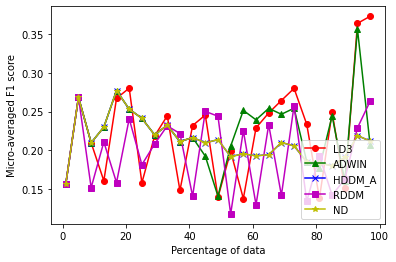

In [87]:
arange = np.arange(1, 101, step=4)
colors = ['ro-', 'g^-', 'bx-', 'ms-', 'y*-']
labels = ['LD3', 'ADWIN', 'HDDM_A', 'RDDM', 'ND']
for i in range(5):
    plt.plot(arange, f1mics_[i], colors[i], label=labels[i])

plt.xlabel('Percentage of data')
plt.xticks([0,20,40,60,80,100])
plt.ylabel('Micro-averaged F1 score')
plt.legend(loc='lower right')
plt.show()

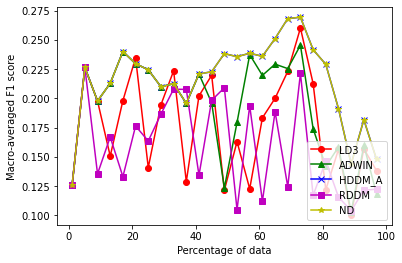

In [88]:
arange = np.arange(1, 101, step=4)
colors = ['ro-', 'g^-', 'bx-', 'ms-', 'y*-']
labels = ['LD3', 'ADWIN', 'HDDM_A', 'RDDM', 'ND']
for i in range(5):
    plt.plot(arange, f1macs_[i], colors[i], label=labels[i])

plt.xlabel('Percentage of data')
plt.xticks([0,20,40,60,80,100])
plt.ylabel('Macro-averaged F1 score')
plt.legend(loc='lower right')
plt.show()

In [89]:
enron_preds = results_pred
enron_true = results_true

In [90]:
from sklearn.neighbors import KernelDensity
model = KernelDensity(bandwidth=1e-1, kernel='gaussian')
sample = np.array(correlation_list).reshape((len(correlation_list), 1))
model.fit(sample)
# sample probabilities for a range of outcomes
values = np.asarray([value for value in np.linspace(-1,1,100)])
values = values.reshape((len(values), 1))
probabilities = model.score_samples(values)
probabilities = np.exp(probabilities)
# plot the histogram and pdf
plt.hist(sample, bins=36, density=True)
plt.plot(values[:], probabilities)
plt.show()

NameError: name 'correlation_list' is not defined

In [ ]:
print(accuracy_score(np.array(y_true), np.array(y_pred)))
print(hamming_score(np.array(y_true), np.array(y_pred)))
print(f1_score(np.array(y_true), np.array(y_pred), average='samples'))
print(f1_score(np.array(y_true), np.array(y_pred), average='micro'))

In [ ]:
a = np.array([1, 19, 3, 8, 5, 18, 4, 2, 0, 13, 11, 7, 17, 6, 9, 10, 12, 14, 15, 16])
b = np.array([19, 1, 2, 7, 3, 5, 18, 17, 13, 4, 8, 11, 0, 10, 6, 12, 9, 14, 15, 16]) 

c = np.array([19, 1, 2, 17, 10, 18, 7, 8, 3, 12, 4, 6, 5, 13, 11, 9, 14, 15, 0, 16])
d = np.array([19, 2, 1, 8, 18, 5, 17, 3, 13, 12, 4, 6, 7, 10, 11, 9, 14, 15, 16, 0]) 

x = np.array([ 1,8,19,5,13,0,17,2,18,11,3,6,9,10,12,4,7,14,15,16 ])
y = np.array([ 19,2,1,8,18,10,12,5,3,4,7,6,11,9,13,17,14,0,15,16 ])

e = np.array([ 8,19,17,1,3,5,0,9,18,2,4,6,11,7,13,12,10,14,15,16 ])
f = np.array([ 19,1,2,8,7,18,5,3,4,13,11,10,17,0,6,12,9,14,15,16 ])

In [ ]:
argx = (np.argsort(a)).astype(np.float)#np.arange(1,21,1).astype(np.float)
argy = (np.argsort(b)).astype(np.float)#np.flip(np.arange(1,21,1)).astype(np.float) 
maxx = np.arange(1,21,1).astype(np.float)
maxy = np.flip(np.arange(1,21,1)).astype(np.float) 

'''for i in range(20):
    argx[i] *= 1/(argx[i]+1)
    argy[i] *= 1/(argy[i]+1)
    maxx[i] *= 1/(maxx[i]+1)
    maxy[i] *= 1/(maxy[i]+1)'''



In [ ]:
print(argx)
print(argy)

In [ ]:
def WS(rx, ry):
    sum_ = 0
    ranks_x = np.argsort(rx)
    ranks_y = np.argsort(ry)
    for i in range(len(rx)):
        sum_ += (1/(2**(ranks_x[i]))) * ((np.abs(ranks_x[i] - ranks_y[i]))/(np.max([np.abs(1-ranks_x[i]), np.abs(len(rx) - ranks_x[i])])))
    return 1 - sum_

In [ ]:
WS(e,f)

In [ ]:
a = [1,2,3,4,5]
b = [5,4,3,2,1]
WS(a, b)

In [ ]:
from scipy.stats import kendalltau, spearmanr
spearmanr(x[:5],y[:5])

In [ ]:
from scipy.spatial.distance import correlation
correlation(argx,argy)

In [ ]:
def dist(x, y, w):
    sum_ = 0
    for i in range(len(x)):
        abs_ = np.abs(x[i] - y[i])
        add =  abs_*w[i] if abs_ > 1 else 0
        sum_ += add
    return sum_
        

In [ ]:
from scipy.spatial import distance
((dist(argx, argy, w=1/((3)**(argy*argy))) / np.sqrt(len(argx))) + (dist(argx, argy, w=1/((3)**(argx*argx))) / np.sqrt(len(argx)))) / 2 #/ 0.05617535148406078

In [ ]:
def rank_correlation(x, y, dist=distance.correlation):
        c = np.array([dist(x[i], y[i]) * (1/((y[i]))) for i in range(len(x))]).sum()
        return c
rank_correlation(argx, argy)

In [ ]:
1/argy

In [ ]:
from scipy.spatial import distance
dist = distance.cityblock # * 1/((argy[i])**2)
s = np.array([dist(argx[i], argy[i]) * 1/((argy[i])**2) for i in range(20)]).sum()

'''for i in range(20):
    s += dist(argx[i], argy[i]) * 1/((argy[i])**2)'''

smax = 0
for i in range(20):
    smax += dist(argx[i], argx[i]) * 1/((argy[i])**2)

print(s)

In [ ]:
0.5429113076754074
55.77
weigher = lambda r: 1/((1+r)**2)
print(weightedtau(a,b,rank=True, additive=False, weigher=weigher))
print(weightedtau(c,d,rank=True, additive=False, weigher=weigher))
print(weightedtau(x,y,rank=True, additive=False, weigher=weigher))

In [ ]:
print(np.where(a==b)[0])
print(np.where(c==d)[0])
print(np.where(x==y)[0])

In [ ]:
weigher = lambda r: 1/((r+1))
print(weightedtau(np.argsort(a),np.argsort(b),rank=False, additive=False, weigher=weigher))
print(weightedtau(np.argsort(c),np.argsort(d),rank=False, additive=False, weigher=weigher))
print(weightedtau(np.argsort(x),np.argsort(y),rank=False, additive=False, weigher=weigher))